<a href="https://colab.research.google.com/github/Adithyan-mp/deep_learning/blob/main/Untitled32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

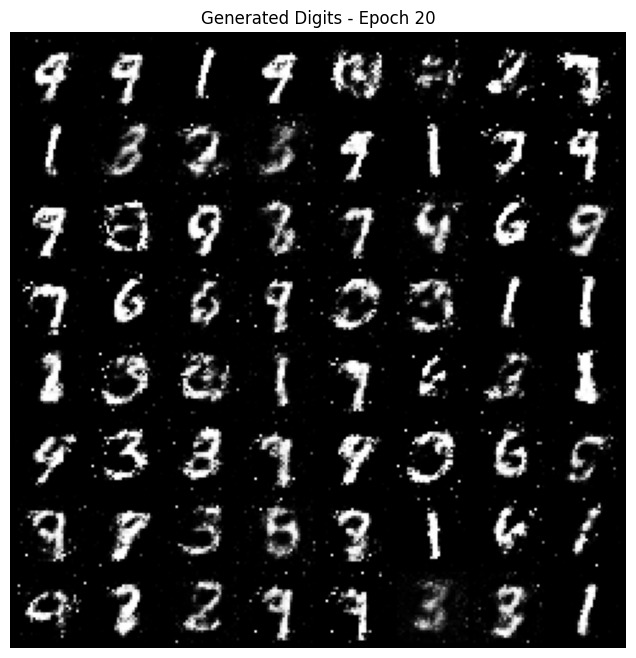

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import time


latent_dim = 100
batch_size = 128
lr = 0.0002
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()


for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch = real_imgs.size(0)

        valid = torch.ones(batch, 1, device=device)
        fake = torch.zeros(batch, 1, device=device)


        optimizer_G.zero_grad()
        z = torch.randn(batch, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()


        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


    with torch.no_grad():
        z = torch.randn(64, latent_dim, device=device)
        gen_imgs = generator(z).cpu()
        gen_imgs = (gen_imgs + 1) / 2

        grid = vutils.make_grid(gen_imgs, nrow=8, normalize=True)
        npimg = np.transpose(grid.numpy(), (1, 2, 0))

        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Generated Digits - Epoch {epoch+1}")
        plt.imshow(npimg)
        plt.show()
        time.sleep(0.1)
